In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from einops import rearrange
from tqdm import tqdm
from geocube.api.core import make_geocube
from scipy.ndimage import generic_filter, gaussian_filter, convolve
from shapely import Point, box
import seaborn as sns




import cv2

root = Path.cwd()

In [2]:
class DataStack():
    """Class containing processed data for input into minimum noise fraction"""
    def __init__(self,root,year,site_name,epsg):
        self.root = root
        #os.makedirs(self.root / 'sentinel_data' / site_name,exist_ok=True)
        self.folder = site_name
        self.year = year
        self.site_name = site_name
        self.epsg = int(epsg)

        b = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}.nc')
        self.input_data = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.y_coords = self.input_data.y.values
        self.x_coords = self.input_data.x.values

        self.season_data = None

        f1 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc'
        if os.path.isfile(f1):
            self.aligned_data = xr.open_dataarray(f1)
        else:
            self.aligned_data = None 

        f2 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc'
        if os.path.isfile(f2):
            self.all_variables = xr.open_dataarray(f2)
        else:
            self.all_variables = None

        f3 = self.root / 'output' / self.site_name.upper() / f'basal_area_{self.site_name.upper()}.nc'
        if os.path.isfile(f3):
            aa = xr.open_dataset(f3)
            self.basal_area = aa    # dataset containing basal area/categories for each species
        else:
            self.basal_area = None
            
        
        f4 = self.root / 'output' / self.site_name.upper() / f'{self.site_name.upper()}_endmember_beech.gpkg'
        if os.path.isfile(f4):
            self.endmember_manual = gpd.read_file(f4)
        else:
            self.endmember_manual = None
        
        self.labels = [os.path.join(self.root / 'output' / self.site_name.upper(),x) for x in os.listdir(self.root / 'output' / self.site_name.upper()) if x.endswith('labels.csv')]
        
        f5 = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_diffs_summerminusfall.nc)'
        if os.path.isfile(f5):
            self.diffs = xr.open_dataarray(f5)
        else:
            self.diffs = None

        self.mnf_input = None

    def plot_input_data(self,band):
        self.input_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)

    def plot_season_data(self,band):
        if self.season_data is not None:
            self.season_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: select_season_data()')
    
    def plot_aligned_data(self,band):
        if self.aligned_data is not None:
            self.aligned_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: coregister_data()')
    
    def select_season_data(self,date_list): # input date_list based on manual inspection of input data
        e = [str(x) for x in self.input_data.time.values if any(date in str(x) for date in date_list)]
        self.season_data =  self.input_data.sel(time=e)
    
    def get_gradient(self,im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_data(self):
    
        # replace nas with 0
        b_sel = self.season_data.where(~np.isnan(self.season_data), other=0)
        # create reference image: mean of all temporal steps
        reference_image = self.season_data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = reference_image.where(~np.isnan(reference_image), other=0)

        # convert input data to numpy float32 numpy arrays
        reference_image = np.float32(reference_image.to_numpy())
        im = np.float32(b_sel.to_numpy())

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        warp_mode = cv2.MOTION_AFFINE
       
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        # loop over time and band dimensions and apply coregistration to each band
        # TODO: calculate warp_matrix for only one band per timestamp and apply to all bands
        for i in tqdm(range(0,time)):
            # set empty warp matrix
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            # calculate warp matrix based on red band
            (_, warp_matrix) = cv2.findTransformECC(self.get_gradient(reference_image), self.get_gradient(im[i,2,:,:]),warp_matrix, warp_mode, criteria)    
            # apply transformation to each band 
            for j in range(0,band):                                                 
                im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
                

        b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
        b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
    

        self.aligned_data = b_align
        b_align.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc')
        print(f'coregisterd bands saves to {self.root} / sentinel_data / {self.folder} / {self.year}_{self.site_name}_aligned_bands.nc')

    
    def remove_outliers(self,a,norm=True):
        a = a.where(np.isfinite(a),np.nan)
        if norm == True:
            a = a.where((a >= -1) & (a <= 1))
        else:
            a = a.where((a >= 0) & (a <= 8))
        return a
    
    
    def add_all_variables(self,num_months,num_of_peak_evi_month): # number of months
        if self.aligned_data is None:
            print('need to run method: coregister_data()')
        else:
        # separate all bands onto 1 dimension
            t = np.arange(0,num_months)
            season_list = [f'month{x}' for x in t]

            array_list1 = list()
            for i, season in enumerate(season_list):
                t = self.aligned_data.isel(time=i).reset_coords('time',drop=True)
                t = t.assign_coords({'band':[f'{x}_{season}' for x in self.aligned_data.band.values]})
                array_list1.append(t)

            m1 = xr.concat(array_list1,dim='band')

            # calculate evi, lswi, slavi, psri for each season 
            #season_list = ['month1','month2','month3', etc....]
            array_list2 = list()
            for i in range(0,num_months):
                blue = array_list1[i].sel(band=f'B02_{season_list[i]}')
                green = array_list1[i].sel(band=f'B03_{season_list[i]}')
                red = array_list1[i].sel(band=f'B04_{season_list[i]}')
                nir = array_list1[i].sel(band=f'B8A_{season_list[i]}')
                sw1 = array_list1[i].sel(band=f'B11_{season_list[i]}')
                sw2 = array_list1[i].sel(band=f'B12_{season_list[i]}')
                re2 = array_list1[i].sel(band=f'B06_{season_list[i]}')


                evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
                evi = self.remove_outliers(evi)

                lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
                lswi = self.remove_outliers(lswi)

                slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
                slavi = self.remove_outliers(slavi,norm=False)

                psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
                psri = self.remove_outliers(psri)

                bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
                bright = self.remove_outliers(bright)

                wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
                wet = self.remove_outliers(wet)

                green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
                green = self.remove_outliers(green)

                season_vi = xr.concat([evi,lswi,slavi,psri,bright,wet,green],dim='band')

                array_list2.append(season_vi)

            m2 = xr.concat(array_list2,dim='band')

            m3 = xr.concat([m1,m2],dim='band')

            ## mask non-forest pixels
            self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
            
            # save
            self.all_variables.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc')
            print(f'variables saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_variables.nc')



    # calculate differences for indices of given two months
    def get_season_differences(self,first,second,desc):
        array_list = list()
        for vi in ['evi', 'lswi', 'slavi','psri','wet','bright','green']:
            d = self.all_variables.sel(band=f'{vi}_{first}') - self.all_variables.sel(band=f'{vi}_{second}')
            d = d.expand_dims({'band':[f'{vi}_{first}_{second}_diff']})
            array_list.append(d)
        
        self.diffs = xr.concat(array_list,dim='band')
        self.diffs.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{desc}.nc')
        print(f'diffs saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_diffs_{desc}.nc')


    def run_pca(self,n,monthstouse,bandstouse,diff_desc,output_desc,save=False):
        
        e = [x for x in self.all_variables.band.values if (any(y in x for y in monthstouse) & any(z in x for z in bandstouse))]
        a1 = self.all_variables.sel(band=e)

        d_list = []
        for desc in diff_desc:
            d1 = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{desc}.nc')
            f = [x for x in d1.band.values if any(y in x for y in bandstouse)]
            d1 = d1.sel(band=f)
            d_list.append(d1)
        d = xr.concat(d_list,dim='band')

        a2 = xr.concat([a1,d],dim='band')
        a = a2.values 

        a_2d = rearrange(a, 'c h w -> (h w) c')
        # drop all na from data
        a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(a_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(a2d_dropna)

        
        pca = PCA(n_components=n)
        pca.fit(data_scaled)
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {np.cumsum(pca.explained_variance_ratio_)}')
        
            
        # replace nans that were dropped earlier
        output_array = np.full((a_2d.shape[0],pca_data.shape[1]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(a_2d.shape[0]), row_indices)  # get indices that don't have na values
        output_array[non_nan_indices] = pca_data

        # # reshape to original dimensions
        height = self.all_variables.shape[1]
        width = self.all_variables.shape[2]
        new_pca_data = rearrange(output_array, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                            coords={'band': np.arange(0,n),'y': self.all_variables.y,'x': self.all_variables.x}, 
                            dims=['band','y','x'])
        # todo: return object with explained variance, plot function etc.
        if save is True:
            pca_array.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{output_desc}.nc')
            print(f'pca saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_pca_{output_desc}.nc')
        
        return pca, pca_array


    # def plot_pca(self,rows,n_comps):
    #     fig = plt.subplots(figsize=(20,5))
    #     for i in range(0,n_comps):
    #         plt.subplot(rows, n_comps, i+1)
    #         self.pca.isel(band=i).plot()
    #     plt.show()

    def make_mnf_input(self, v1, v2,month,diff_desc):
        """
        Assemble given version for input to MNF(), assuming existence of saved requisite .nc files

        v1 = 'gs' or 'ssf' (growing season or spring-summmer-fall)
        v2 = 'tc' or 'nontc' (tasseled cap or non tasseled cap)
        month = 'month0, month1.....monthn' specifies month for which to include all bands and indices
        diff_desc = which diff version to use

        """
        # select specified month
        if len(month) == 1:
            e = [x for x in self.all_variables.band.values if month[0] in x]
            a = self.all_variables.sel(band=e)
        else:
            e = [x for x in self.all_variables.band.values if (any(y in x for y in month))]
            a = self.all_variables.sel(band=e)
        
        if v2 == 'tc':
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','bright','green','wet'])]
            a = a.sel(band=f)
        else:
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','lswi','slavi','psri'])]
            a = a.sel(band=f)

        pca = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{v1}_{v2}.nc')
        #pca = pca.isel(band=slice(0,10))

        b = xr.concat([a,pca],dim='band')

        if len(diff_desc) > 1:

            d = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[0]}.nc')

            if v2 == 'tc':
                f = [x for x in d.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                d = d.sel(band=f)
            else:
                f = [x for x in d.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                d = d.sel(band=f)

            c = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[1]}.nc')

            if v2 == 'tc':
                f = [x for x in c.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                c = c.sel(band=f)
            else:
                f = [x for x in c.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                c = c.sel(band=f)
                b = xr.concat([a,d,c,pca],dim='band')

        else:
            d = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[0]}.nc')

            if v2 == 'tc':
                    f = [x for x in d.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                    d = d.sel(band=f)
            else:
                f = [x for x in d.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                d = d.sel(band=f)
            b = xr.concat([a,d,pca],dim='band')

        self.mnf_input = b

           



In [3]:
bart_data = DataStack(root,2019,'bart',26919)
harv_data = DataStack(root,2018,'harv',26918)
#roi1.plot_input_data(band=3)

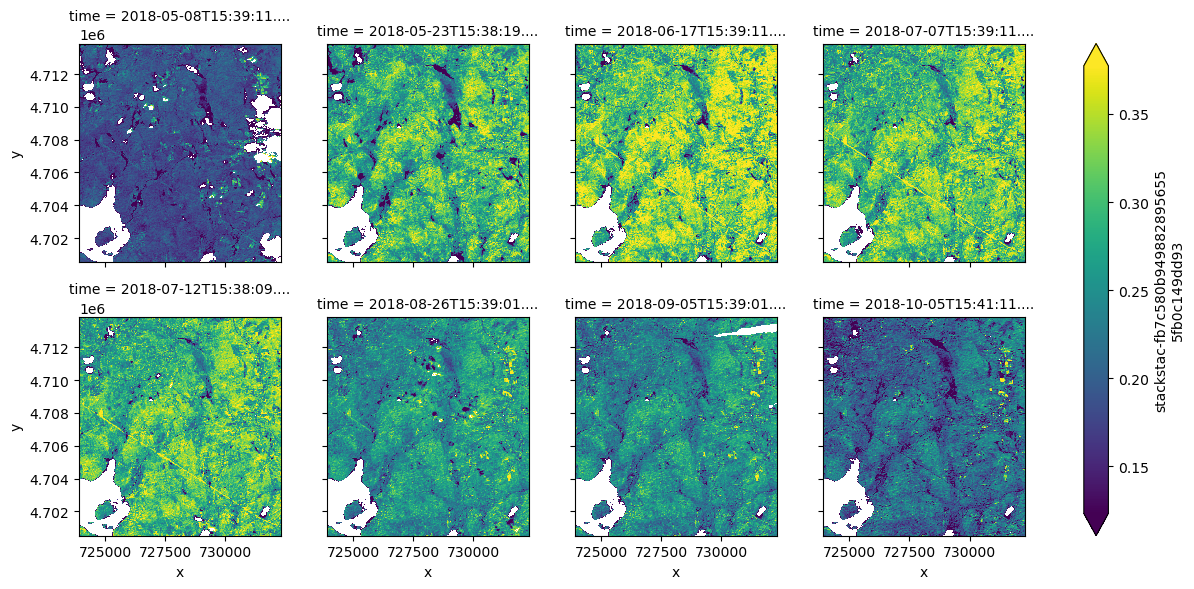

In [5]:
harv_data.plot_input_data(band=4)

In [6]:
harv_data.select_season_data(date_list=['05-08','06-17','07-07','08-26','09-05','10-05'])
harv_data.coregister_data() 

100%|██████████| 6/6 [29:50<00:00, 298.44s/it]


coregisterd bands saves to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / sentinel_data / harv / 2018_harv_aligned_bands.nc


In [7]:
harv_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/harv/2018_harv_variables.nc


In [8]:
harv_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/harv/2018_harv_diffs_summerminusspring.nc


In [369]:
suny_data = DataStack(root,2018,'suny',26918)
# suny_data.select_season_data(date_list=['05-11','06-30','07-20','08-09','09-13','10-13'])
# suny_data.coregister_data()
# suny_data.plot_season_data(band=3)

In [7]:
suny_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_variables.nc


In [8]:
suny_data.get_season_differences('month2','month5','summerminusfall')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_diffs_summerminusfall.nc


In [ ]:
# manually inspect input data and select the timestamps to keep
bart_data.select_season_data(date_list=['05-08','06-12','07-07','08-26','09-20','10-15'])
bart_data.plot_season_data(band=3)

In [ ]:
bart_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bartlett/2019_bart_variables.nc


In [259]:
bart_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bart/2019_bart_diffs_summerminusspring.nc


In [260]:
suny_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_diffs_summerminusspring.nc


In [9]:
gs_months=['month1','month2','month3'] # june, july, august
ssf_months=['month0','month2','month5'] # may, july, october

ssf2_months = ['month0','month2','month4'] # may, july, september

all_months = ['month0','month1','month2','month3','month4','month5']

eos_months = ['month3','month4','month5'] # august,september, october
sos_months = ['month0','month1','month2'] # may, june, july

tc_bands = ['B','evi','bright','green','wet']
nontc_bands = ['B','evi','lswi','slavi','psri']

# nontc pca still has tc vars for differences
# nontc2 uses nontc for differences

p1, p2 = harv_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusspring'],output_desc='ssf_nontc2_diffspring',save=True)

# p1, p2 = bart_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusfall','summerminusspring'],output_desc='ssf_nontc2_diffboth',save=True)

# p1, p2 = suny_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusfall','summerminusspring'],output_desc='ssf_nontc2_diffboth',save=True)

explained variance: [0.36004388 0.5802164  0.7193401  0.81696093 0.86454636 0.89580506
 0.9229388  0.94135684 0.953148   0.9615827  0.96891695 0.9747751
 0.97919655 0.98242295 0.98462623]
pca saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/harv/2018_harv_pca_ssf_nontc2_diffspring.nc


### Minimum Noise Fraction

In [10]:
class MNF():
    def __init__(self,mnf_image,noise_bbox,noise_cov_matrix,reg_noise_cov_matrix,whitening_matrix,basal_area,labels,root,site_name,epsg):
        self.mnf_image = mnf_image

        self.noise_bbox = noise_bbox
        self.noise_cov_matrix = noise_cov_matrix
        self.reg_noise_cov_matrix = reg_noise_cov_matrix
        self.whitening_matrix = whitening_matrix
        self.basal_area = basal_area
        self.labels = labels
        self.root = root
        self.site_name = site_name
        self.epsg = epsg
        
    
    def plot_noise_region(self):
        bx, by = self.noise_bbox.exterior.xy

        plt.imshow(self.mnf_image[0,:,:])
        plt.fill(bx,by,edgecolor='red',facecolor='red',alpha=0.4)
    
    def check_noise_cov_matrix(self):
        # check stability of noise covariance matrix
        determinant = np.linalg.det(self.noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.noise_cov_matrix)

        print(f'original matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

        determinant = np.linalg.det(self.reg_noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.reg_noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.reg_noise_cov_matrix)

        print(f'regularized matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

    def check_noise_whitening(self):
        whitened_noise_cov = self.whitening_matrix @ self.reg_noise_cov_matrix @ self.whitening_matrix.T

        plt.imshow(whitened_noise_cov)  # if resembles identity matrix, whitening is applied correctly
    
    def plot_mnf_variance(self):
        # plt.figure(figsize=(12, 6))
        # for i in range(10):  
        #     plt.subplot(2, 5, i + 1)
        #     plt.imshow(self.mnf_image[i,:, :])
        #     plt.title(f"MNF Band {i+1}")
        # plt.show()

        variance = [np.nanvar(self.mnf_image[i,:,:])for i in range(10)]

        plt.plot(np.arange(0,len(variance)),variance)
        plt.show()
        
        
# get noise region based on variance
def get_noise_region_variance(data,percentile):
    
    image = data[0:3,:,:]
    #image = data
    #apply window, calculate variance
    variance_map = np.mean([generic_filter(image[b,:, :], lambda x: np.var(x), size=13) for b in range(image.shape[0])], axis=0)
    # find areas with variance < percentile
    x_2d = rearrange(variance_map,'h w -> (h w)')
    varmap_dropna = x_2d[~np.isnan(x_2d)]   
    threshold = np.percentile(varmap_dropna, percentile)
    low_var = variance_map < threshold
    #extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

# get noise region based on otsu thresholding
def get_noise_region_otsu(data): 
    data_array = data.values
    image_rearrange = rearrange(data_array,'c h w -> h w c' )
    image = image_rearrange[:,:,0:3]
    im = np.ma.masked_invalid(image)

    im_norm = im / np.max(im) # normalize the data to 0 - 1
    im_scale = 255 * im_norm # scale by 255
    im_u8 = im_scale.astype(np.uint8) # convert to uint 8
    img = cv2.cvtColor(im_u8, cv2.COLOR_BGR2GRAY) 
    # applying Otsu thresholding 
    # as an extra flag in binary  
    # thresholding      
    ret, low_var = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + 
                                                cv2.THRESH_OTSU) 

    # extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

def estimate_noise(image):
    noise = np.zeros_like(image)
    
    # Compute noise for each band
    for b in range(image.shape[0]):
        x_ij = image[b,:, :]
        x_ip1_j = np.roll(x_ij, shift=-1, axis=0)  # Shift left (i+1, j)
        x_i_jp1 = np.roll(x_ij, shift=-1, axis=1)  # Shift up (i, j+1)
        
        # Compute noise 
        noise[b, :, :] = x_ij - 0.5 * (x_ip1_j + x_i_jp1)
    
    return noise

def estimate_noise_gaussian(img):
  
    # Generate Gaussian noise with mean=0, std=0.012 (same shape as image)
    rnoisy = np.random.normal(0, 0.012, size=img.shape)

    # Compute per-channel RMS (Root Mean Square) value
    rms = np.sqrt(np.nanmean(img ** 2, axis=(1, 2), keepdims=True))

    # Scale noise by image RMS 
    noise = rms * rnoisy

    return noise

def get_noise_cov_matrix(noise_matrix):
    
    noise = rearrange(noise_matrix, 'c h w -> (h w) c')

    # remove nans
    noise = noise[~np.isnan(noise).any(axis=1)]  # Remove rows with NaNs
   
    cov = np.cov(noise,rowvar=False)
    
    return cov

def check_matrix(n_cov_matrix):
# check stability of noise covariance matrix
    determinant = np.linalg.det(n_cov_matrix) # should be greater than 10e-10
    condition = np.linalg.cond(n_cov_matrix) # should be below 10e7

    eigvals = np.linalg.eigvals(n_cov_matrix)

    # data_variance = np.nanvar(data, axis=(1,2))  # Variance across spatial dimensions
    # mean_data_variance = np.mean(data_variance)
    # mean_data_variance

    print(f'determinant: {determinant}\ncondition: {condition}\neigen min: {np.min(eigvals)}\neigen max: {np.max(eigvals)}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}\neigvals: {eigvals}')

####### adding regularization term gives more numerically resonable output ###########
def regularize_noise(noise_cov_matrix):
    lambda_reg = 1e-1 * np.eye(noise_cov_matrix.shape[0])  # diagonal offset
    reg_cov_matrix = noise_cov_matrix + lambda_reg 

    return reg_cov_matrix


def get_ba_threshold(basal_area):
    r = basal_area.values
    r = r[~np.isnan(r)]

    return round(np.percentile(r,99),3)

def get_endmembers(ba,mnf,ts):  # return pixels with > 99th percentile of basal area
    #thresh = get_ba_threshold(ba)
    h = ba
    #rows, cols = np.where(h>=thresh)
    
   
    if np.nanmax(h.values) < 100:
        thresh = get_ba_threshold(h)
        rows, cols = np.where(h>=thresh)
    else:
        rows, cols = np.where(h==100.0)
    
    pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
    print(f'found {len(pixels)} pixels where {ts} is {np.nanmax(h.values)} percent basal area')
  

    p_list = []

    for i in range(0,len(pixels)):
        p_list.append(mnf.values[:,pixels[i][0],pixels[i][1]])

    p_array = np.array(p_list) 
    

    p_mean = np.nanmean(p_array,axis=0)

    return p_array, p_mean

def get_endmembers_manual(em, mnf):
    r = em.get_coordinates()

    v = []
    for i in range(r.shape[0]):
        value = mnf.sel(x=r.iloc[i,0], y=r.iloc[i,1], method="nearest").values
        v.append(value)

    v_mean = np.mean(v,axis=0)

    return v, v_mean
    
def create_mnf_image(datastack,n1,n2,reg=True):
    # takes in DataStack object
    # outputs MNF object with:
        # noise region bbox
        # noise covariance matrix
        # mnf image
        # endmembers in mnf space
    data = datastack.mnf_input.values[n1:n2,:,:]
    

    noise_region, noise_bbox = get_noise_region_variance(data, 30) # first three bands only

    noise = estimate_noise_gaussian(noise_region)
    ############ step 1: whiten data ###########
    n_cov_matrix = get_noise_cov_matrix(noise)
    if reg == True:
        reg_n_cov_matrix = regularize_noise(n_cov_matrix)
        eigvals, eigvecs = np.linalg.eigh(reg_n_cov_matrix)
    else:
        eigvals, eigvecs = np.linalg.eigh(n_cov_matrix)
        reg_n_cov_matrix = None


    # mean correct and reshape the data 
    m = np.nanmean(data, axis=0)
    data = data - m
    reshaped_data = rearrange(data,'b h w -> b (h w)') 

    # Compute the whitening matrix 
    inv_sqrt_eigenvalues = np.diag(1.0 / np.sqrt(eigvals))  # Compute R = Λ^(-1/2)
    whitening_matrix = eigvecs @ inv_sqrt_eigenvalues @ eigvecs.T  \
    # apply whitening transform
    whitened_data = whitening_matrix @ reshaped_data

    ####### step 2: PCA rotation #######
    # drop nas before applying pca
    whitened_data = rearrange(whitened_data,'c r -> r c')
    dropna = whitened_data[~np.isnan(whitened_data).any(axis=1)]
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(whitened_data))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped 

    # pca on whitened data; needs to be in form (rows, columns)
    pca = PCA()
    mnf = pca.fit_transform(dropna)

    # replace nans that were dropped earlier
    output_array = np.full((whitened_data.shape[0],mnf.shape[1]), np.nan)  # create array of correct shape
    non_nan_indices = np.setdiff1d(np.arange(whitened_data.shape[0]), row_indices) 
    output_array[non_nan_indices] = mnf

    # Reshape back to image format
    mnf_image = rearrange(output_array,'(h w) b -> b h w',h=data.shape[1],w=data.shape[2])


    # convert to xarray with geographic coodinates
    band_names = [f'comp_{x}' for x in range(mnf_image.shape[0])]
    mnf_image = xr.DataArray(mnf_image, coords={'band': band_names,'y': datastack.y_coords, 'x': datastack.x_coords},dims=['band','y','x'])
    
    ########### get endmembers ###############
    # if em_manual == True:
    #     endmember_array, endmember_mean = get_endmembers_manual(datastack.endmember_manual, mnf=mnf_image)
    # else:
    #     endmember_array, endmember_mean = get_endmembers(datastack.basal_area, mnf_image)

    return MNF(mnf_image = mnf_image,noise_bbox=noise_bbox, noise_cov_matrix=n_cov_matrix, reg_noise_cov_matrix=reg_n_cov_matrix,whitening_matrix=whitening_matrix,basal_area=datastack.basal_area,labels=datastack.labels,root=datastack.root,site_name=datastack.site_name,epsg=datastack.epsg)





# get cov matrix of mnf, find how many eigenvalues are > threshold, select that number of components from mnf image
def get_num_high_signal_components(mnf_image,thresh):
    mnf_2d = rearrange(mnf_image, 'c h w -> (h w) c')
    mnf_dropna = mnf_2d[~np.isnan(mnf_2d).any(axis=1)]  # Remove rows with NaNs
    mnf_cov = np.cov(mnf_dropna,rowvar=False)
    mnf_eigvals, _ = np.linalg.eigh(mnf_cov)
    return len(mnf_eigvals[mnf_eigvals>=thresh]), mnf_eigvals

def make_2d_input_data(data):
    x_2d = rearrange(data,'c h w -> (h w) c')
    x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
    
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(x_2d))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

    return x_2d, x_dropna, row_indices

def replace_na_and_reshape(data_2d,final_data,indices,shape):
# replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
    return r
    


def mixture_tuned_matched_filter(mnf_object,SNR,mean=True,array_num=0,target_species='beech'):
    # takes in MNF object
    # outputs array with MF score, IF score, and basal area bands

    # add get endmembers here
    # mnf_object.basal_area[f'{target_species}_basal_area']
    endmember_array, endmember_mean = get_endmembers(mnf_object.basal_area[f'{target_species}_basal_area'], mnf_object.mnf_image,ts=target_species)


    ###### select MNF components to use###########
    t = SNR # threshold for eigenvalues
    n, eigvals = get_num_high_signal_components(mnf_object.mnf_image.values,t)
    mnf = mnf_object.mnf_image.values[:n,:,:]
    print(f'{n} MNF components used with eigvals between {np.min(eigvals[eigvals>=t])} and {np.max(eigvals[eigvals>=t])}')

    # Target spectral signature 
    if mean == True:
        #target = mnf_object.em_mean[:n]
        target = endmember_mean[:n]
    else:
        #target = mnf_object.em_array[array_num][:n]
        target = endmember_array[array_num][:n]
    # background mean 
    #u_b = np.nanmean(mnf, axis=(1, 2))  
    # difference between target and background mean - not present in Mundt
    #d_tb = (target- u_b)
    ############ matched filter ######################
    # Calculate the covariance matrix of the background
    mnf_2d, mnf_dropna, na_indices = make_2d_input_data(mnf) 
    C = np.cov(mnf_dropna, rowvar=False)  

    det = np.linalg.det(C) # should be greater than 10e-10
    cond = np.linalg.cond(C) # should be below 10e7
    print(f'mnf covariance matrix:\n  determinant: {det}\n  condition: {cond}')
    C1 = np.linalg.inv(C)
    #epsilon = 1e-6  # Small regularization term
    #C1 = np.linalg.inv(C + epsilon * np.eye(C.shape[0]))

    # Normalization coefficient 
    coef = 1.0 / target @ C1 @ target
    
    A = (coef * target) @ C1 # transformation matrix
    Y = (A @ mnf_dropna.T).T

    matched_filter = replace_na_and_reshape(mnf_2d,Y,na_indices,mnf.shape)

    print(f'MF max: {np.nanmax(matched_filter)}, MF min: {np.nanmin(matched_filter)}, MF mean: {np.nanmean(matched_filter)}')

    

    ######## infeasibility score #################

    # Compute target vector component 
    target_component = matched_filter[..., np.newaxis] * target  # Shape: (H, W, D)
    target_component = rearrange(target_component,'h w d -> d h w')

    eigvals, _ = np.linalg.eigh(C) # C = covariance matrix of mnf image
    # Compute interpolated eigenvalues; scale mnf eigenvalues based on the MF scores
    noise = np.ones((n,))  # size corresponds to number of components; noise has unit variance

    sqrt_eig = np.sqrt(eigvals)  
    interp_eig = (sqrt_eig - matched_filter[..., np.newaxis] * (sqrt_eig - noise))**2  

    interp_eig = np.where(interp_eig == 0, 1e-6, interp_eig)  # Avoid divide-by-zero issues
    interp_eig = rearrange(interp_eig,'h w d -> d h w')

    r = mnf - target_component
    r_2d, r_dropna, r_indices = make_2d_input_data(r)

    r_norm = np.linalg.norm(np.nan_to_num(r_dropna),axis=1)
    r2 = replace_na_and_reshape(r_2d,r_norm,r_indices,mnf.shape)

    e_2d, e_dropna, e_indices = make_2d_input_data(interp_eig)

    s = np.linalg.norm(np.nan_to_num(e_dropna,nan=1e-6),axis=1)
    s2 = replace_na_and_reshape(e_2d,s,e_indices,mnf.shape)

    infeas_score = r2/s2

    print(f'infeas max: {np.nanmax(infeas_score)}, infeas min: {np.nanmin(infeas_score)}, infeas mean: {np.nanmean(infeas_score)}')

    matched_filter = xr.DataArray(matched_filter, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    infeas_score = xr.DataArray(infeas_score, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    q = xr.concat([matched_filter,infeas_score,mnf_object.basal_area[f'{target_species}_basal_area'],mnf_object.basal_area[f'{target_species}_category']],dim='band')
    q = q.assign_coords({'band':[f'{target_species}_mf_score',f'{target_species}_infeas_score',f'{target_species}_basal_area',f'{target_species}_categories']})
    
    return MTMF(array=q,target=target,target_species=target_species,labels=mnf_object.labels,root=mnf_object.root,site_name=mnf_object.site_name,epsg=mnf_object.epsg)



class MTMF():
    def __init__(self,array,target,target_species,labels,root,site_name,epsg):
        self.result_array = array
        self.target = target
        self.matched_filter = self.result_array.sel(band=f'{target_species}_mf_score').values
        self.infeas_score = self.result_array.sel(band=f'{target_species}_infeas_score').values
        self.basal_area = self.result_array.sel(band=f'{target_species}_basal_area').values
        self.categories = self.result_array.sel(band=f'{target_species}_categories').values
        self.labels = labels
        self.target_species = target_species
        self.root = root
        self.site_name = site_name
        self.epsg = epsg


    def plot_histograms(self):
        fig, ax = plt.subplots(1, 2, figsize=(8,4))

        ax[0].hist(self.matched_filter.flatten(), bins=50)
        ax[0].set_title("Matched Filter")

        ax[1].hist(self.infeas_score.flatten(), bins=50)
        ax[1].set_title("Infeasibility")

        plt.tight_layout()
        plt.show()

    def plot_correlation(self):
        
        # i_2d = rearrange(self.infeas_score,'h w -> (h w)')
        # ba_2d = rearrange(self.basal_area,'h w -> (h w)')
        # t2_2d = rearrange(self.matched_filter,'h w -> (h w)')
        # c_2d = rearrange(self.categories,'h w -> (h w)' )

        # combine = np.vstack((ba_2d,t2_2d,i_2d,c_2d)).T

        # combine = combine[~np.isnan(combine).any(axis=1)]

        # df = pd.DataFrame(combine)
        # df.columns = ['basal_area','mf_score','infeas_score','category']

        df = pd.DataFrame(rearrange(self.result_array.values,'b h w -> (h w) b'),columns=self.result_array.band.values)
        df = df[~np.isnan(df).any(axis=1)]
        df.columns = ['_'.join(x.split('_')[1:]) for x in self.result_array.band.values]
        # read in category labels for target species
        label_df = pd.read_csv([x for x in self.labels if self.target_species in x][0])

        # make dictionary to make sure labels are properly matched to categories
        label_dict = {}
        for i in range(len(label_df)):
                label_dict[str(i)+'.0'] = label_df.loc[i,'cat_labels']


        g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))
        handles, labels = g.get_legend_handles_labels()
        g.legend(handles=handles,labels=[label_dict.get(x) for x in labels])
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    def plot_threshold(self,mf_greaterthan,infeas_lessthan,save=False,epsg=None):
        mask_1 = self.result_array.sel(band='mf_score')>mf_greaterthan
        mask_2 = self.result_array.sel(band='infeas_score')<infeas_lessthan

        threshold = self.result_array.where(mask_1 & mask_2)
        threshold.sel(band='mf_score').plot() 
        
        if save == True:
            threshold = threshold.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
            threshold.sel(band='mf_score').to_netcdf(self.root / 'output' / self.site_name.upper() / f'{self.target_species}_mtmf_result.nc')

        

        
        

    
    


    

In [31]:
e, m = get_endmembers(harv_data.basal_area['beech_basal_area'],harv_mnf.mnf_image,ts='beech')

found 3 pixels where beech is 60.32616918433814 percent basal area


In [29]:
m

np.float64(nan)

In [11]:
# output = MnfInput object (stack of bands to use to calculate mnf)
# months = which months bands to include
# v1, v2 = which version of pca to use
# diff_desc = which difference to use (e.g. 'summerminusfall')

#gs_tc_mnf_input = roi1.make_mnf_input(v1='gs',v2='tc',month='month2',diffs=True,diff_num=0)
bart_data.make_mnf_input(v1='ssf',v2='nontc2_diffspring',month=['month2'],diff_desc=['summerminusspring'])
#ssf_tc_mnf_input = roi1.make_mnf_input(v1='ssf',v2='tc',month='month2',diffs=True,diff_num=0)
harv_data.make_mnf_input(v1='ssf',v2='nontc2_diffspring',month=['month2'],diff_desc=['summerminusspring'])
#suny_data.make_mnf_input(v1='ssf',v2='nontc2_diffboth',month=['month2'],diff_desc=['summerminusspring'])

In [12]:
n1 =18
n2 = 28
#suny_mnf = create_mnf_image(suny_data,n1=n1,n2=n2,reg=True)
bart_mnf = create_mnf_image(bart_data,n1=n1,n2=n2,reg=True)
harv_mnf = create_mnf_image(harv_data,n1=n1,n2=n2,reg=True)

C:\Users\roseh\AppData\Local\Temp\ipykernel_15308\1125212402.py:247: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data, axis=0)
C:\Users\roseh\AppData\Local\Temp\ipykernel_15308\1125212402.py:247: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data, axis=0)


In [ ]:
suny_mtmf = mixture_tuned_matched_filter(suny_mnf,SNR=15,mean=True,array_num=0,target_species='beech')

In [ ]:
suny_mtmf.plot_correlation()

In [56]:
harv_mtmf = mixture_tuned_matched_filter(harv_mnf,SNR=30,mean=True,array_num=0,target_species='birch')

found 1 pixels where birch is 100.0 percent basal area
4 MNF components used with eigvals between 38.7296919301706 and 150.27504126030198
mnf covariance matrix:
  determinant: 30847521.40848197
  condition: 3.8800990602054637
MF max: 0.9665360250611215, MF min: -0.5653248140096497, MF mean: 2.6983120987445976e-16
infeas max: 29.22754080627153, infeas min: 0.0016209810761713026, infeas mean: 0.08850741842894702


C:\Users\roseh\AppData\Local\Temp\ipykernel_15308\1125212402.py:470: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))


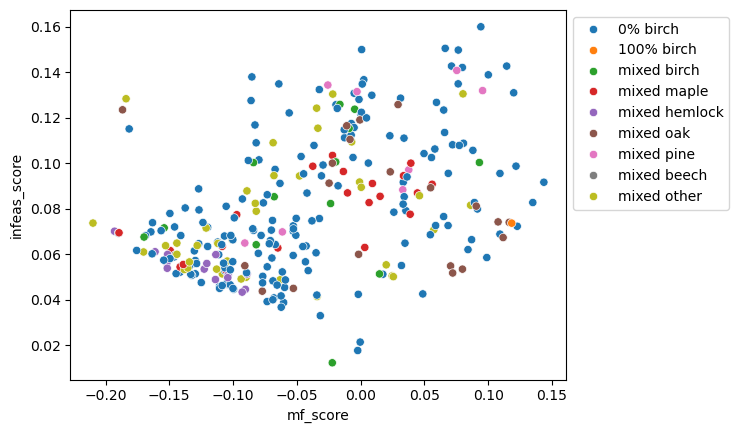

In [57]:
harv_mtmf.plot_correlation()

In [58]:
bart_mtmf = mixture_tuned_matched_filter(bart_mnf,SNR=29,mean=True,array_num=0,target_species='birch')

found 1 pixels where birch is 100.0 percent basal area
3 MNF components used with eigvals between 37.866464080254715 and 204.55527544936555
mnf covariance matrix:
  determinant: 485844.3349656137
  condition: 5.402016808747395
MF max: 0.2851347434493119, MF min: -1.0672058596584202, MF mean: 1.0547122360672853e-16
infeas max: 0.4319343762447737, infeas min: 0.00045452532989681863, infeas mean: 0.06923033211475782


C:\Users\roseh\AppData\Local\Temp\ipykernel_15308\1125212402.py:470: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))


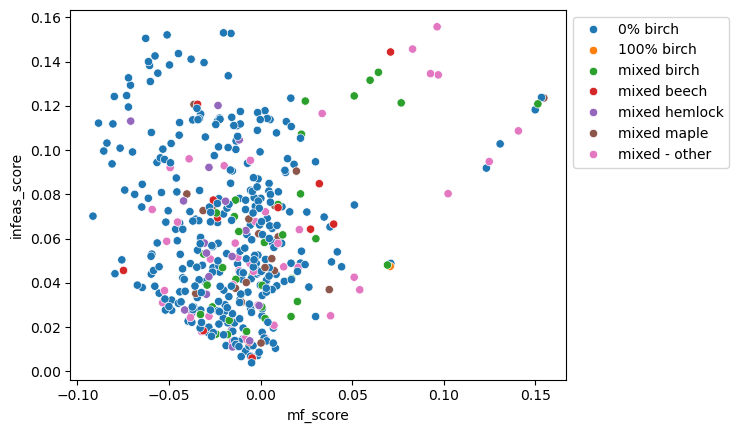

In [59]:
bart_mtmf.plot_correlation()

### Regression/Classification

In [43]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import json
import folium
import io
import base64
import branca.colormap as cm

# functions to align target site mtmf output with training site mtmf output

# def make_df(mtmf_obj):
#         df = pd.DataFrame(rearrange(mtmf_obj.result_array.values,'b h w -> (h w) b'),columns=mtmf_obj.result_array.band.values)
#         df = df[~np.isnan(df).any(axis=1)]
#         df.columns = ['_'.join(x.split('_')[1:]) for x in mtmf_obj.result_array.band.values]
#         return df

# def scale_approach(df1,df2):
        
#         scaler_mf = MinMaxScaler().fit(df1[['mf_score']])
#         scaler_if = MinMaxScaler().fit(df1[['infeas_score']])

#         # Transform both datasets using the same parameters
#         transformed_mf = scaler_mf.transform(df2[['mf_score']])
#         transformed_if = scaler_if.transform(df2[['infeas_score']])

#         df2_copy = df2.copy()
#         df2_copy['mf_score'] = transformed_mf.flatten()  # Convert 2D array to 1D
#         df2_copy['infeas_score'] = transformed_if.flatten() 

#         transformed_mf = scaler_mf.transform(df1[['mf_score']])
#         transformed_if = scaler_if.transform(df1[['infeas_score']])

#         df1_copy = df1.copy()
#         df1_copy['mf_score'] = transformed_mf.flatten()  # Convert 2D array to 1D
#         df1_copy['infeas_score'] = transformed_if.flatten() 

#         return df1_copy,df2_copy

# def shift_approach(df1, df2):
   
#     # Extract beech points (assuming categories identify beech points)
#     beech_mask_A = df1['categories'] == 1.0  
#     beech_mask_B = df2['categories'] == 1.0  
    
#     # Calculate means for beech and non-beech points in both datasets
#     beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
#     beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
    
#     # Calculate the shift needed to align beech points
#     shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
#     shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
    
#     # Create a copy of df2 with scaled columns
#     df2_aligned = df2.copy()
#     df2_aligned['mf_score_scaled'] = df2['mf_score'] + shift_mf
#     df2_aligned['infeas_score_scaled'] = df2['infeas_score'] + shift_infeas
    
#     return df2_aligned

# def shift_approach2(df1, df2):
#     """
#     Aligns dataset B (df2) with dataset A (df1) focusing on both 0% and 100% beech.
#     """
#     # Extract beech and non-beech points
#     beech_mask_A = df1['categories'] == 1.0  # 100% beech category
#     nonbeech_mask_A = df1['categories'] == 0.0  # 0% beech category
    
#     beech_mask_B = df2['categories'] == 1.0
#     nonbeech_mask_B = df2['categories'] == 0.0
    
#     # Calculate centroids for both categories in both datasets
#     beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
#     nonbeech_mean_A = df1[nonbeech_mask_A][['mf_score', 'infeas_score']].mean()
    
#     beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
#     nonbeech_mean_B = df2[nonbeech_mask_B][['mf_score', 'infeas_score']].mean()
    
#     # Use the average shift between both categories
#     shift_mf = ((beech_mean_A['mf_score'] - beech_mean_B['mf_score']) + 
#                 (nonbeech_mean_A['mf_score'] - nonbeech_mean_B['mf_score'])) / 2
                
#     shift_infeas = ((beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']) + 
#                    (nonbeech_mean_A['infeas_score'] - nonbeech_mean_B['infeas_score'])) / 2
    
#     # Apply the shift
#     df2_aligned = df2.copy()
#     df2_aligned['mf_score_scaled'] = df2['mf_score'] + shift_mf
#     df2_aligned['infeas_score_scaled'] = df2['infeas_score'] + shift_infeas
    
#     return df2_aligned

# def scale_and_shift_approach(df1,df2):

#     df1_scale, df2_scale = scale_approach(df1,df2)

#     df2_shift = shift_approach(df1_scale,df2_scale)

#     return df1_scale,df2_shift

# def make_plot(mtmf_obj1,mtmf_obj2,scale):
#         df1 = make_df(mtmf_obj1)
#         df2 = make_df(mtmf_obj2)

#         if scale == True:
#                 df1,df2 = scale_and_shift_approach(df1,df2)
#         else:
#                 df2 = shift_approach(df1,df2)  # shift mean of beech points

#         # read in category labels for target species
#         label_df1 = pd.read_csv([x for x in mtmf_obj1.labels if mtmf_obj1.target_species in x][0])
#         # make dictionary to make sure labels are properly matched to categories
#         label_dict1 = {}
#         for i in range(len(label_df1)):
#                 label_dict1[str(i)+'.0'] = label_df1.loc[i,'cat_labels']

#         # read in category labels for target species
#         label_df2 = pd.read_csv([x for x in mtmf_obj2.labels if mtmf_obj2.target_species in x][0])
#         # make dictionary to make sure labels are properly matched to categories
#         label_dict2 = {}
#         for i in range(len(label_df2)):
#                 label_dict2[str(i)+'.0'] = label_df2.loc[i,'cat_labels']

#         fig, axes = plt.subplots(1, 3, figsize=(20, 5))  #  row,  columns    
#         axes = axes.ravel()   

#         g = sns.scatterplot(data=df1, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'),ax=axes[0])
#         handles, labels = g.get_legend_handles_labels()
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         g.set_title('Bartlett Data')
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         g = sns.scatterplot(data=df2, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'),ax=axes[1])
#         handles, labels = g.get_legend_handles_labels()
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         g.set_title('Site Data')
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         g = sns.scatterplot(data=df2, x='mf_score_scaled', y='infeas_score_scaled', hue='categories',palette=sns.color_palette('tab10'),ax=axes[2])
#         handles, labels = g.get_legend_handles_labels()
#         g.set_title('Site Data Scaled')
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         plt.tight_layout()
#         plt.show()


# make_plot(mtmf_obj1=bart_mtmf,mtmf_obj2=suny_mtmf,scale=True)
# make_plot(mtmf_obj1=bart_mtmf,mtmf_obj2=suny_mtmf,scale=False)

class ModelDeployer():
    def __init__(self,train_data_obj,target_data_obj,target_species,type='clf'):
        self.root = train_data_obj.root
        self.train_site_name = train_data_obj.site_name
        self.target_site_name = target_data_obj.site_name
        self.target_epsg = target_data_obj.epsg
        self.train_epsg = train_data_obj.epsg
        self.train_data_array = train_data_obj.result_array
        self.target_data_array = target_data_obj.result_array
        self.target_species = target_species
        self.train_site_labels = train_data_obj.labels
        self.target_site_labels = target_data_obj.labels

        self.train_site_df = self.make_df(type='train_site')
        self.target_site_df = self.make_df(type='target_site')
        self.target_site_shifted_df, _, _ = self.translation_transform(self.train_site_df,self.target_site_df)

        self.ind_vars = [x for x in self.train_site_df.columns if any(y in x for y in ['mf_score','infeas_score'])]
        self.X = self.train_site_df.loc[:,self.ind_vars].values
        if type == 'clf':
            self.y = self.train_site_df.loc[:,'binary'].values
        else:
            self.y = self.train_site_df.loc[:,'basal_area'].values

        f1 = self.root / 'output' / self.train_site_name.upper() / 'param_dicts.json'   
        if os.path.isfile(f1):
            param_dict = json.load( open( f1) )  # load saved parameters if file exists
            self.clf_mlp_params = param_dict['clf_mlp_params']
            self.clf_xg_params = param_dict['clf_xg_params']
            self.clf_gbm_params = param_dict['clf_gbm_params']
            self.clf_rf_params = param_dict['clf_rf_params']
            self.reg_mlp_params = param_dict['reg_mlp_params']
            self.reg_xg_params = param_dict['reg_xg_params']
            self.reg_gbm_params = param_dict['reg_gbm_params']
            self.reg_rf_params = param_dict['reg_rf_params']
       
            # model objects initialized with optimized parameters from saved param dictionaries
        
            self.clf_mlp = MLPClassifier(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

            
            self.clf_xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

            self.clf_gbm = GradientBoostingClassifier(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

            self.clf_rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])

            self.reg_mlp = MLPRegressor(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

            self.reg_xgboost = xgb.XGBRegressor(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

            self.reg_gbm = GradientBoostingRegressor(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

            self.reg_rf = RandomForestRegressor(ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])

            # calibrated versions of tuned clf models
            self.clf_mlp_cal = CalibratedClassifierCV(self.clf_mlp,cv=5,method='isotonic')
            self.clf_xgboost_cal = CalibratedClassifierCV(self.clf_xgboost,cv=5,method='isotonic')
            self.clf_gbm_cal = CalibratedClassifierCV(self.clf_gbm,cv=5,method='isotonic')
            self.clf_rf_cal = CalibratedClassifierCV(self.clf_rf,cv=5,method='isotonic')

            ### add reg models

            self.prediction = None

        else:
            print('optimized parameter dicitonary does not exist. need to train models with ModelBuilder()')

    def make_df(self,type):
        
        if type == 'train_site':
            m = self.train_data_array
        else:
            m = self.target_data_array

        out_df = pd.DataFrame(rearrange(m.values,'b h w -> (h w) b'),columns=m.band.values)
        out_df = out_df[~np.isnan(out_df).any(axis=1)]
        out_df.columns = ['_'.join(x.split('_')[1:]) for x in m.band.values]

        conditions_binary = [(out_df['basal_area']==0.0),
                    out_df[f'basal_area']>0.0
                    ]
        binary_cats = [0,1]
        out_df['binary'] = np.select(conditions_binary,binary_cats, default=0)
        
        return out_df
    
    def translation_transform(self,df1, df2):
        # shift target data based on 100% beech points in train site data
        # Extract beech points only
        beech_mask_A = df1['categories'] == 1.0  
        beech_mask_B = df2['categories'] == 1.0  
        if 1.0 in df2['categories']:
            beech_mask_B = df2['categories'] == 1.0 
        else:
            beech_mask_B = df2['basal_area']>0
        
        # Calculate means 
        beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
        beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
        
        # Calculate the difference in means
        shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
        shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
        
        # Create a copy of df2 with scaled columns
        df2_aligned = df2.copy()
        df2_aligned['mf_score'] = df2['mf_score'] + shift_mf
        df2_aligned['infeas_score'] = df2['infeas_score'] + shift_infeas
        
        return df2_aligned, shift_mf, shift_infeas
        
    def plot_input_data(self):
            # read in category labels for target species
            label_df1 = pd.read_csv([x for x in self.train_site_labels if self.target_species in x][0])
            # make dictionary to make sure labels are properly matched to categories
            label_dict1 = {}
            for i in range(len(label_df1)):
                    label_dict1[str(i)+'.0'] = label_df1.loc[i,'cat_labels']

            # read in category labels for target species
            label_df2 = pd.read_csv([x for x in self.target_site_labels if self.target_species in x][0])
            # make dictionary to make sure labels are properly matched to categories
            label_dict2 = {}
            for i in range(len(label_df2)):
                    label_dict2[str(i)+'.0'] = label_df2.loc[i,'cat_labels']

            # get xlims
            all_x_values = pd.concat([
            self.train_site_df['mf_score'],
            self.target_site_df['mf_score'],
            self.target_site_shifted_df['mf_score']
        ])
            x_min, x_max = all_x_values.min(), all_x_values.max()

            all_y_values = pd.concat([
            self.train_site_df['infeas_score'],
            self.target_site_df['infeas_score'],
            self.target_site_shifted_df['infeas_score']
        ])
            y_min, y_max = all_y_values.min(), all_y_values.max()

            fig, axes = plt.subplots(1, 3, figsize=(20, 5))  #  row,  columns    
            axes = axes.ravel()   

            g = sns.scatterplot(data=self.train_site_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.train_site_df['categories'].nunique()),ax=axes[0])
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
            g.set_title(f'{self.train_site_name.title()} Data')
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            g = sns.scatterplot(data=self.target_site_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.target_site_df['categories'].nunique()),ax=axes[1])
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles=handles,labels=[label_dict2.get(x) for x in labels])
            g.set_title(f'{self.target_site_name.title()} Data')
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            g = sns.scatterplot(data=self.target_site_shifted_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.target_site_shifted_df['categories'].nunique()),ax=axes[2])
            handles, labels = g.get_legend_handles_labels()
            g.set_title(f'{self.target_site_name.title()} Shifted Data')
            g.legend(handles=handles,labels=[label_dict2.get(x) for x in labels])
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            plt.tight_layout()
            plt.show()

    
    def check_clf_model_calibration(self):
       
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)

        # fit calibrated models
        self.clf_mlp_cal.fit(X_train,y_train)
        self.clf_xgboost_cal.fit(X_train,y_train)
        self.clf_gbm_cal.fit(X_train,y_train)
        self.clf_rf_cal.fit(X_train,y_train)

        # fit regular models
        self.clf_mlp.fit(X_train,y_train)
        self.clf_xgboost.fit(X_train,y_train)
        self.clf_gbm.fit(X_train,y_train)
        self.clf_rf.fit(X_train,y_train)

        models = {
            "MLP Uncalibrated": self.clf_mlp,
            "MLP Calibrated" : self.clf_mlp_cal,
            "XGBoost Uncalibrated": self.clf_xgboost,
            "XGBoost Calibrated" : self.clf_xgboost_cal,
            "RF Uncalibrated": self.clf_rf,
            "RF Calibrated": self.clf_rf_cal

        }
        # Create subplots
        fig, axes = plt.subplots(4, 2, figsize=(10, 10))  # 2x4 
        axes = axes.flatten()  # flatten for indexing

        # Loop through models and plot CalibrationDisplay
        for idx, (name, model) in enumerate(models.items()):
            CalibrationDisplay.from_estimator(model, X_test, y_test, ax=axes[idx],name=name)
            axes[idx].set_title(name)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()
        
    
    def compare_clf_model_results(self,shift=True):
        
        models = {
            "MLP Calibrated" : self.clf_mlp_cal,
            "XGBoost Calibrated" : self.clf_xgboost_cal,
            "RF Calibrated": self.clf_rf_cal
        }

        results = {'model': [],'recall':[],'precision':[]}
        cms = {}
        for name, model in models.items():
            for i in range(5):
                X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)
                model.fit(X_train,y_train)
                # score = model.score(X_test,y_test)
                # results['model'].append(name)
                # results['score'].append(score)

                predictions = model.predict(X_test)
                cm = confusion_matrix(y_test, predictions, labels=model.classes_)
                cms[name] = cm
                results['model'].append(name)
                results['precision'].append(precision_score(y_test,predictions,labels=model.classes_))
                results['recall'].append(recall_score(y_test,predictions,labels=model.classes_))


        r = pd.DataFrame(results)

        r = r.groupby('model').agg({'recall':['mean','std'],'precision':['mean','std']}).reset_index()
        r.columns = r.columns.droplevel(0)
        r.columns = ['model','recall','recall_std', 'precision', 'precision_std']
        r['site'] = self.train_site_name
        self.local_cms = cms

    

        ########## target site #######
    
        results = {'model': [],'recall':[], 'recall_std': [], 'precision':[], 'precision_std':[]}
        cms = {}
        for name, model in models.items():
            # test on non-local data
            if shift == True:
                X_test = self.target_site_shifted_df.loc[:,self.ind_vars].values
                y_test = self.target_site_shifted_df.loc[:,'binary'].values
            else:
                X_test = self.target_site_df.loc[:,self.ind_vars].values
                y_test = self.target_site_df.loc[:,'binary'].values

            model.fit(self.X,self.y)  # fit on all data
            #score = model.score(X_test,y_test)
            results['model'].append(name)
            

            predictions = model.predict(X_test)
            cm = confusion_matrix(y_test, predictions, labels=model.classes_)
            cms[name] = cm

            results['precision'].append(precision_score(y_test,predictions,labels=model.classes_))
            results['recall'].append(recall_score(y_test,predictions,labels=model.classes_))
            results['precision_std'] = np.nan
            results['recall_std'] = np.nan

        r2 = pd.DataFrame(results)
        r2['site'] = self.target_site_name

        r3 = pd.concat([r,r2],axis=0)
        self.result_df = r3
        self.target_cms = cms


    def plot_clf_model_results(self):
        
        pivoted = self.result_df.pivot(index='model', columns='site', values='mean_score')
        pivoted_std = self.result_df.pivot(index='model', columns='site', values='std')

        ax = pivoted.plot(kind='bar', yerr=pivoted_std, capsize=5, title='Accuracy Score', ylabel='F1', xlabel='Model', legend=True)
        ax.set_ylim(0.0, 1.0)
        ax.set_xticklabels([x.split(' ')[0] for x in pivoted.index], rotation=0)

        plt.tight_layout()
        plt.show()
    

    def plot_confusion_matrices(self,site):
        if site == self.train_site_name:
            cms = self.local_cms
        else:
            cms = self.target_cms
            
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x4 
        axes = axes.flatten() 

        for idx, (name, cm) in enumerate(cms.items()):
        
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[idx], cmap='Blues',colorbar=False) 
            axes[idx].set_title(name)

        plt.tight_layout() 
        plt.show()

    def predict_raster(self,model,target=True,shift=True):
        if target == True:
            p = self.target_data_array
            epsg = self.target_epsg
        else:
            p = self.train_data_array
            epsg = self.train_epsg
      
        df = pd.DataFrame(rearrange(p.values,'b h w -> (h w) b'),columns=p.band.values)
        df.columns = ['_'.join(x.split('_')[1:]) for x in p.band.values]
        df = df.loc[:,self.ind_vars]

        na_indices = np.where(np.isnan(df))
        row_indices = np.unique(na_indices[0])
        df_dropna = df[~np.isnan(df).any(axis=1)]

        # apply shift
        if shift == True:
            _, shift_mf, shift_infeas = self.translation_transform(self.train_site_df,self.target_site_df)

            df_dropna.loc[:,'mf_score'] = df_dropna['mf_score'] + shift_mf
            df_dropna.loc[:,'infeas_score'] = df_dropna['infeas_score'] + shift_infeas

        # select user specified model
        model_dict = {'clf_xgboost':self.clf_xgboost_cal,'clf_rf':self.clf_rf_cal,'clf_mlp':self.clf_mlp_cal} #TODO: add reg models
        mod = model_dict[model]

        mod.fit(self.X,self.y) # fit on all available data
        predicted_probs = mod.predict_proba(df_dropna.values)[:,1]

        output = np.full((df.shape[0]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(df.shape[0]), row_indices)  # get indices that don't have na values
        output[non_nan_indices] = predicted_probs

        shape = p.shape
        output = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
        out_array = xr.DataArray(output, coords={'y': p.y.values, 'x': p.x.values},dims=['y','x'])
        out_array = out_array.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.prediction = out_array

    def create_image_overlay(self,data, lats, lons):
    
        # Create a temporary image
        fig, ax = plt.subplots(figsize=(10, 10))
        img = ax.imshow(data, cmap='viridis', origin='upper')
        plt.axis('off')
        
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        
        # Get bounds for overlay
        min_lat, max_lat = lats.min(), lats.max()
        min_lon, max_lon = lons.min(), lons.max()
        bounds = [[min_lat, min_lon], [max_lat, max_lon]]
        
        plt.close(fig)
        
        return img_str, bounds
    
    def map_predictions(self):

        output_4326 = self.prediction.rio.reproject('EPSG:4326')
        output_4326 = output_4326 * 100

        # find coordinates for map center
        lats = output_4326.y.values
        lons = output_4326.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='OpenStreetMap')

        # create color map
        colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        img_str, bounds = self.create_image_overlay(output_4326, lats, lons)

        # overlay in-memory image on folium map
        folium.raster_layers.ImageOverlay(
            image=f"data:image/png;base64,{img_str}",  
            bounds=bounds,
            opacity=1
        ).add_to(m)

        colormap.caption = 'Probability Beech (%)'
        colormap.add_to(m)

        return m
        

In [44]:
md = ModelDeployer(bart_mtmf,harv_mtmf,'hemlock')

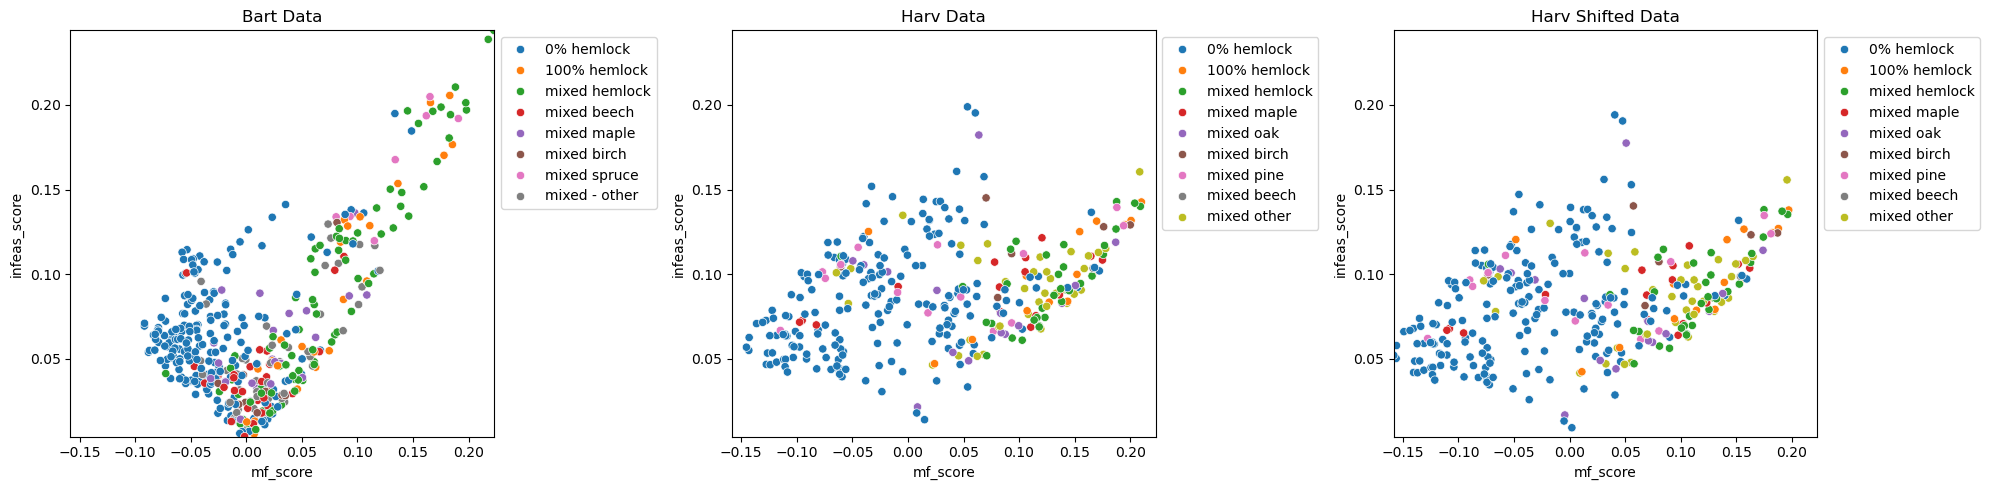

In [45]:
md.plot_input_data()

In [35]:
md.compare_clf_model_results(shift=True) 

In [36]:
md.result_df

,model,recall,recall_std,precision,precision_std,site
0,MLP Calibrated,0.839177,0.084201,0.790839,0.042490,bart
1,RF Calibrated,0.858374,0.042652,0.796314,0.057638,bart
2,XGBoost Calibrated,0.852335,0.079473,0.798030,0.038206,bart
0,MLP Calibrated,0.829630,NaN,0.682927,NaN,harv
1,XGBoost Calibrated,0.814815,NaN,0.687500,NaN,harv
2,RF Calibrated,0.829630,NaN,0.678788,NaN,harv


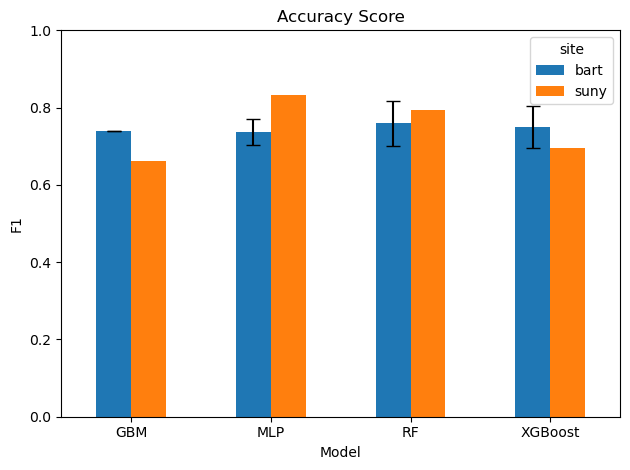

In [35]:
md.plot_clf_model_results()

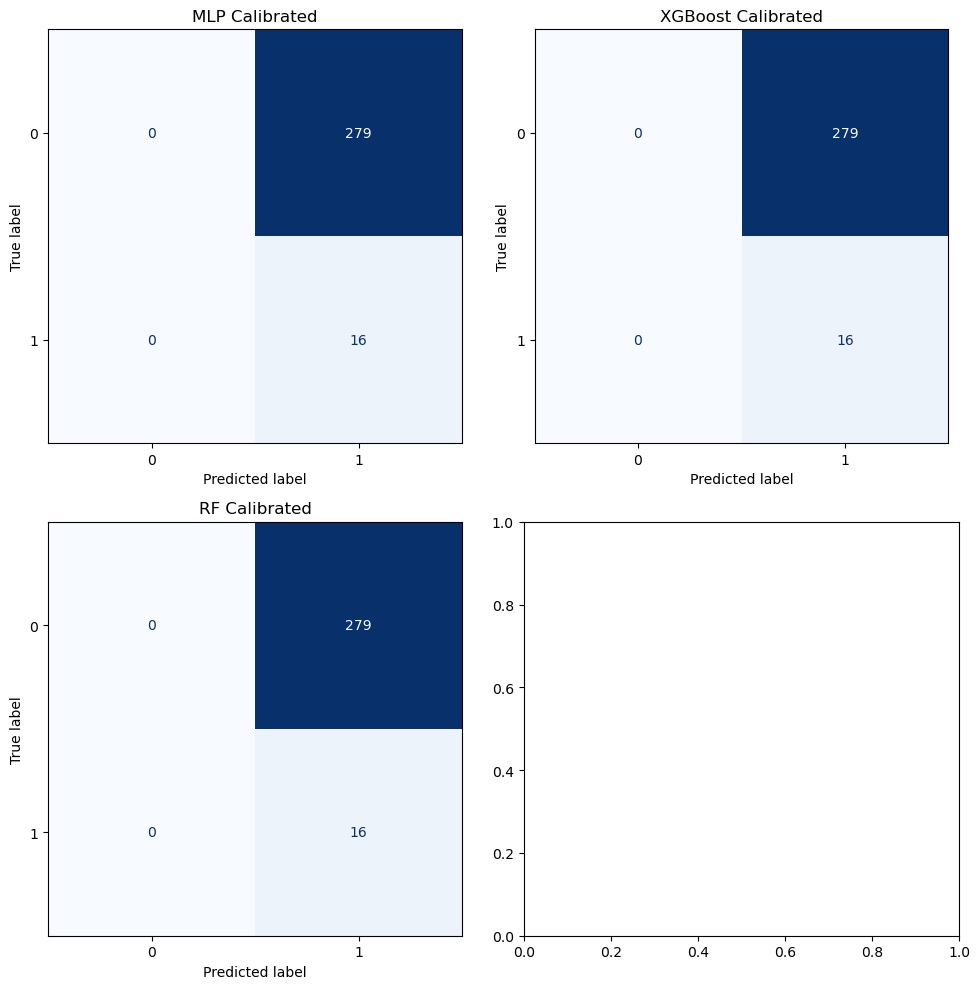

In [74]:
md.plot_confusion_matrices(site='harv')

In [114]:
md.predict_raster(model='clf_rf')


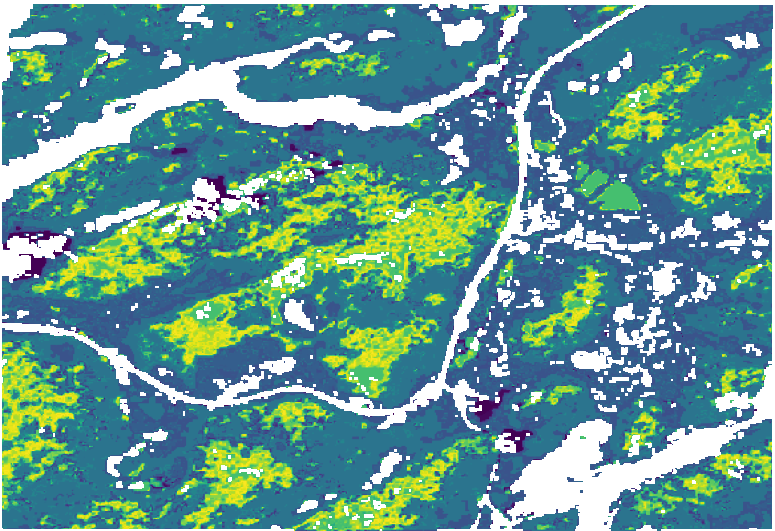

In [115]:
m = md.map_predictions()

m

In [16]:
class ModelBuilder():
    def __init__(self,mtmf_object,target_species,clf_type='binary'):
        self.root = mtmf_object.root
        self.site_name = mtmf_object.site_name
        self.result_array = mtmf_object.result_array
        self.target_species = target_species
        self.df = self.make_training_df()
        
        self.ind_vars = [x for x in self.df.columns if any(y in x for y in ['mf_score','infeas_score'])]
        self.X = self.df.loc[:,self.ind_vars].values
        self.y = self.df.loc[:,clf_type].values

        self.results_log = {'regression':[],'classification':[]}
        self.result_df = None
        self.confusion_matrices = None

        self.reg_param_grids = {
                    "mlp":          {
                                    'hidden_layer_sizes': Integer(100,200), 
                                    'activation':Categorical(['relu']), 
                                    'solver':Categorical(['lbfgs']), # lbfgs more suited to smaller datasets
                                    'alpha': Real(0.0001,0.1,'log-uniform'),  
                                    'max_iter':Integer(10000,50000),  
                                    'max_fun':Integer(10000,15000)
                                    },

                    "randomforest": {"n_estimators": Integer(100,200),
                                    "min_samples_split": Integer(20,50),
                                    'min_samples_leaf': Integer(20,50),
                                    'ccp_alpha':Real(1e-6,0.1,'log-uniform')},

                    "xgboost":      {'max_depth': Integer(1,5),
                                    'learning_rate':Real(1e-6,0.1,'log-uniform'),
                                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                                    'reg_lambda': Real(1e-6,0.2,'log-uniform'), # L2 regularization of weights
                                    'n_estimators':Integer(50,200)
                                    #'early_stopping_rounds':[10]
                                    },

                    'gbm':          {'learning_rate':Real(0.3,1.0,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                                    'n_estimators':Integer(500,2000),
                                    'max_depth': Integer(1,10),
                                    'n_iter_no_change': Integer(1,30),
                                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
                }
        self.clf_param_grids = {
                "mlp":          {
                                'hidden_layer_sizes': Integer(80,110), 
                                'activation':Categorical(['identity', 'logistic', 'tanh', 'relu']), 
                                'solver':Categorical(['lbfgs','sgd','adam']), # lbfgs more suited to smaller datasets
                                'alpha': Real(0.05,0.1,'log-uniform'),  
                                'max_iter':Integer(10000,10100),  
                                'max_fun':Integer(10000,10100)
                                },

                "randomforest": {"n_estimators": Integer(200,1000),
                                "criterion":Categorical(['gini','entropy','log_loss']),
                                "min_samples_split": Integer(2,20),
                                'min_samples_leaf': Integer(1,20),
                                'max_samples': Real(0.1,1.0,'log-uniform'),
                                'ccp_alpha':Real(1e-6,0.1,'log-uniform')
                                },
                "xgboost":      {'max_depth': Integer(1,5),
                                'learning_rate':Real(0.1,0.5,'log-uniform'),
                                'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                                'reg_lambda': Real(0.2,0.5,'log-uniform'), # L2 regularization of weights
                                'n_estimators':Integer(10,100),
                                'subsample':Real(1e-6,1.0,'log-uniform'),
                                'scale_pos_weight': Real(0.5,1.0,'log-uniform')  # weight applied to positive class instances
                                #'early_stopping_rounds':[10]
                                },

                'gbm':          {'learning_rate':Real(0.01,0.5,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                                'n_estimators':Integer(1000,2000),
                                'subsample':Real(0.5,1.0,'log-uniform'),
                                'max_depth': Integer(5,15),
                                'n_iter_no_change': Integer(5,15),
                                'validation_fraction':Real(0.01,0.1,'log-uniform'),
                                'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
            }

        self.reg_models =  {
                                "mlp": MLPRegressor(),
                                "xgboost": xgb.XGBRegressor(),
                                "gbm": GradientBoostingRegressor(),
                                'randomforest': RandomForestRegressor()
                            }
        self.clf_models = {
                "mlp": MLPClassifier(),
                "xgboost": xgb.XGBClassifier(objective='binary:logistic'),
                "gbm": GradientBoostingClassifier(),
                'randomforest': RandomForestClassifier(class_weight='balanced')
            }

    
    def make_training_df(self):
   
        m = self.result_array

        out_df = pd.DataFrame(rearrange(m.values,'b h w -> (h w) b'),columns=m.band.values)
        out_df = out_df[~np.isnan(out_df).any(axis=1)]

        conditions_binary = [(out_df[f'{self.target_species}_basal_area']==0.0),
                    out_df[f'{self.target_species}_basal_area']>0.0
                    ]
        binary_cats = [0,1]
        out_df['binary'] = np.select(conditions_binary,binary_cats, default=0)
        
        return out_df

    def save_optimized_parameters(self):
        param_dict = {'clf_mlp_params':self.clf_mlp_params,'clf_xg_params':self.clf_xg_params,'clf_rf_params':self.clf_rf_params,'clf_gbm_params':self.clf_gbm_params,'reg_mlp_params':self.reg_mlp_params,'reg_xg_params':self.reg_xg_params,'reg_rf_params':self.reg_rf_params,'reg_gbm_params':self.reg_gbm_params}

        json.dump(param_dict,open(self.root / 'output' / self.site_name.upper() / 'param_dicts.json','w'))
        print(f'tuned params saved to {self.root} / output / {self.site_name.upper()} / param_dicts.json')
    
    def tune_regression_models(self):

        # split training data
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)


        cv = KFold(n_splits=5, shuffle=True, random_state=0) # random state ensures we compare performance on the same data

        results = []
        for name, model in self.reg_models.items():
            grid_search = BayesSearchCV(
                estimator=model,
                search_spaces=self.reg_param_grids[name],
                return_train_score=True,
                scoring='neg_root_mean_squared_error',
                cv=cv
                ).fit(X_train, y_train)

            param_dict = grid_search.best_params_
            param_dict['model'] = name
            param_dict['test_rmse'] = (np.abs(grid_search.score(X_test,y_test)))
            param_dict['train_rmse'] = (np.abs(grid_search.best_score_))
            results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
            
        self.results_log['regression'].append(param_dict)
        return pd.concat(results)
    
           
    def tune_classification_models(self):
        # make training data

        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)


        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

        results = []
        for name, model in self.clf_models.items():
            grid_search = BayesSearchCV(
            estimator=model,
            search_spaces=self.clf_param_grids[name],
            return_train_score=True,
            scoring='f1',
            cv=cv
            ).fit(X_train, y_train)

            param_dict = grid_search.best_params_
            param_dict['model'] = name
            param_dict['test_f1'] = (grid_search.score(X_test,y_test))
            param_dict['train_f1'] = (grid_search.best_score_)
            results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
        self.results_log['classification'].append(results)
        return pd.concat(results)
    
    
        #out_array.to_netcdf(root / 'output' / 'BART' / 'xgboost_probs_bart.nc')

In [66]:
bm = ModelBuilder(bart_mtmf,target_species='beech',clf_type='binary')

In [ ]:
# set parameter search grids for tuning
bm.clf_param_grids['mlp'] = {'hidden_layer_sizes': Integer(low=50, high=100, prior='uniform', transform='normalize'),
 'activation': Categorical(categories=(['relu']), prior=None),
 'solver': Categorical(categories=('lbfgs', 'sgd', 'adam'), prior=None),
 'alpha': Real(low=0.05, high=0.7, prior='log-uniform', transform='normalize'),
 'max_iter': Integer(low=5000, high=10000, prior='uniform', transform='normalize'),
 'max_fun': Integer(low=5000, high=10015, prior='uniform', transform='normalize')}

bm.clf_param_grids['xgboost'] = {'max_depth': Integer(low=1, high=3, prior='uniform', transform='normalize'),
 'learning_rate': Real(low=0.1, high=0.2, prior='log-uniform', transform='normalize'),
 'gamma': Real(low=1e-06, high=1e-4, prior='log-uniform', transform='normalize'),
 'reg_lambda': Real(low=0.1, high=0.3, prior='log-uniform', transform='normalize'),
 'n_estimators': Integer(low=5, high=20, prior='uniform', transform='normalize'),
 'subsample': Real(low=1e-06, high=1.0, prior='log-uniform', transform='normalize'),
 'scale_pos_weight': Real(low=0.8, high=1.0, prior='log-uniform', transform='normalize')}

bm.clf_param_grids['randomforest'] = {'n_estimators': Integer(low=400, high=800, prior='uniform', transform='normalize'),
 'criterion': Categorical(categories=(['entropy']), prior=None),
 'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
 'max_samples': Real(low=0.1, high=0.5, prior='log-uniform', transform='normalize'),
 'ccp_alpha': Real(low=1e-06, high=1e-05, prior='log-uniform', transform='normalize')}

bm.clf_param_grids['gbm'] = {'learning_rate': Real(low=0.1, high=0.5, prior='log-uniform', transform='normalize'),
 'n_estimators': Integer(low=1000, high=1050, prior='uniform', transform='normalize'),
 'subsample': Real(low=0.3, high=0.6, prior='log-uniform', transform='normalize'),
 'max_depth': Integer(low=10, high=20, prior='uniform', transform='normalize'),
 'n_iter_no_change': Integer(low=5, high=15, prior='uniform', transform='normalize'),
 'validation_fraction': Real(low=0.01, high=0.05, prior='log-uniform', transform='normalize'),
 'ccp_alpha': Real(low=0.005, high=0.02, prior='log-uniform', transform='normalize')}


In [37]:
round1 = bm.tune_classification_models()


In [56]:
round2 = bm.tune_classification_models()

In [ ]:
# set optimized parameters
bm.clf_mlp_params = {'hidden_layer_sizes':50, 'activation':'relu','solver':'adam', 'alpha':0.42, 'max_iter':10000, 'max_fun':10015}
bm.clf_xg_params = {'gamma':0,'learning_rate':0.2,'max_depth':3,'n_estimators':20,'reg_lambda':0.1}
bm.clf_gbm_params = {'ccp_alpha':0.0,'learning_rate':0.1,'max_depth':10,'n_estimators':1050,'n_iter_no_change':15,'subsample':0.6,'validation_fraction':0.01}
bm.clf_rf_params = {'n_estimators':700, 'criterion':'entropy', 'max_depth':None, 'min_samples_split':10, 'min_samples_leaf':2,  'ccp_alpha':0.0, 'max_samples':0.35}

# save parameter dictionaries
bm.save_optimized_parameters()

tuned params saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / output / BART / param_dicts.json


c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

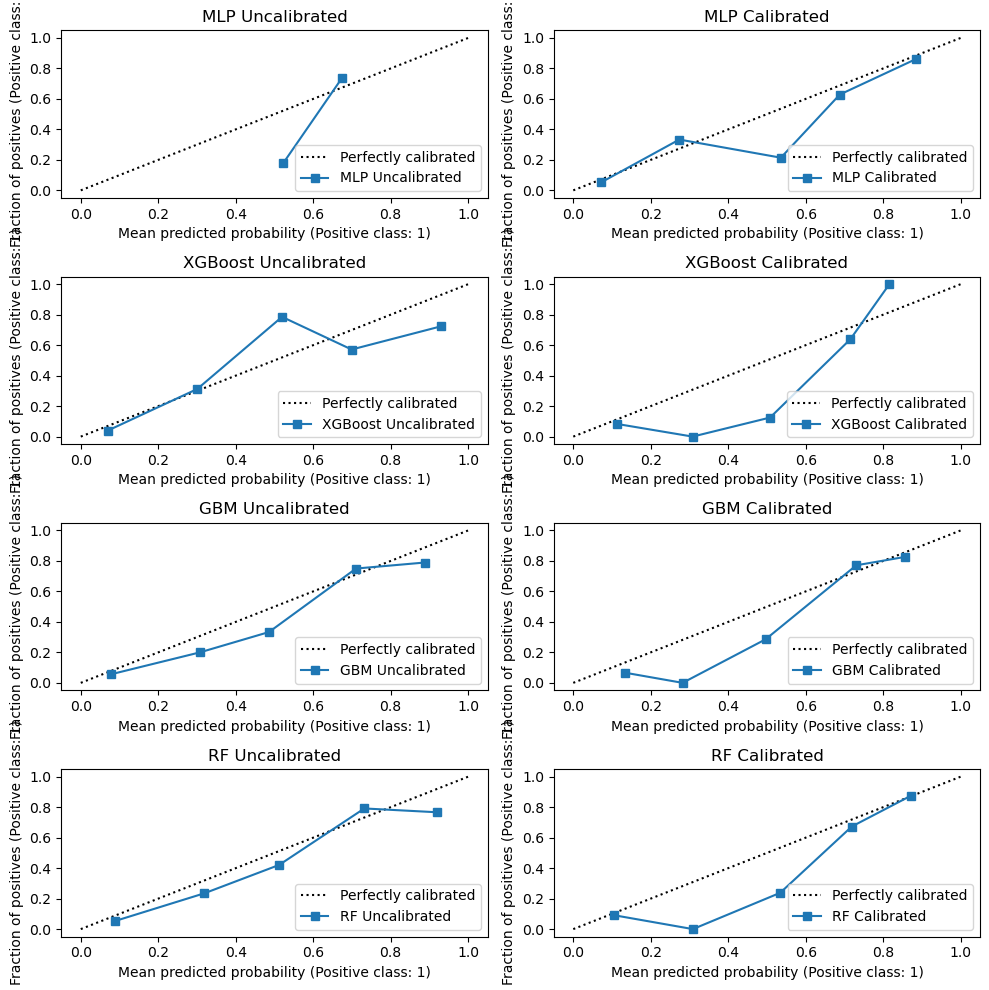

In [68]:
bm.check_clf_model_calibration()

In [ ]:
# try using sklearn.ensemble.StackingRegressor after regressors are all optimized
# or sklearn.multioutput.RegressorChain

def tune_regression_models(df,target_species,param_grids):

    # make training data
    ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
    X = df.loc[:,ind_vars].values
    y = df.loc[:,f'{target_species}_basal_area'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

    models = {
        "mlp": MLPRegressor(),
        "xgboost": xgb.XGBRegressor(),
        "gbm": GradientBoostingRegressor(),
        'randomforest': RandomForestRegressor()
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    results = []
    for name, model in models.items():
        grid_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_grids[name],
            return_train_score=True,
            scoring='neg_root_mean_squared_error',
            cv=cv
            ).fit(X_train, y_train)

        param_dict = grid_search.best_params_
        param_dict['model'] = name
        param_dict['test_rmse'] = (np.abs(grid_search.score(X_test,y_test)))
        param_dict['train_rmse'] = (np.abs(grid_search.best_score_))
        results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))

    return pd.concat(results)

def add_category_columns(df,target_species):

    conditions_binary = [(df[f'{target_species}_basal_area']==0.0),
                df[f'{target_species}_basal_area']>0.0
                ]
    binary_cats = [0,1]

    conditions_3cats = [(df[f'{target_species}_basal_area']==0.0),
                (df[f'{target_species}_basal_area']>0.0)&(df[f'{target_species}_basal_area']<50.0),
                #(df['basal_area']>=50.0)&(df['basal_area']<=100.0)
                df[f'{target_species}_basal_area']>=50.0
                ]
    three_cats = [0,1,2]

    df['three_categories'] = np.select(conditions_3cats,three_cats, default=0)
    df['binary'] = np.select(conditions_binary,binary_cats, default=0)

    return df




    

In [ ]:
reg_param_grids = {
    "mlp":          {
                    'hidden_layer_sizes': Integer(100,200), 
                    'activation':Categorical(['relu']), 
                    'solver':Categorical(['lbfgs']), # lbfgs more suited to smaller datasets
                    'alpha': Real(0.0001,0.1,'log-uniform'),  
                    'max_iter':Integer(10000,50000),  
                    'max_fun':Integer(10000,15000)
                    },

    "randomforest": {"n_estimators": Integer(100,200),
                     "min_samples_split": Integer(20,50),
                     'min_samples_leaf': Integer(20,50),
                     'ccp_alpha':Real(1e-6,0.1,'log-uniform')},

    "xgboost":      {'max_depth': Integer(1,5),
                    'learning_rate':Real(1e-6,0.1,'log-uniform'),
                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                    'reg_lambda': Real(1e-6,0.2,'log-uniform'), # L2 regularization of weights
                    'n_estimators':Integer(50,200)
                    #'early_stopping_rounds':[10]
                    },

    'gbm':          {'learning_rate':Real(0.3,1.0,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                    'n_estimators':Integer(500,2000),
                    'max_depth': Integer(1,10),
                    'n_iter_no_change': Integer(1,30),
                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
}

result_round3 = tune_regression_models(df=beech_df,target_species='beech',param_grids=reg_param_grids)

In [ ]:
# recategorize to 0%, 100%, >50%, <50%

# pipeline: TargetEncoder()


#clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric='auc',early_stopping_rounds=10)  #"multi:softprob"

beech_df = add_category_columns(beech_df,'beech')

In [9]:
beech_df = pd.read_csv(root / 'output' / 'BART' / 'mtmf_df_output.csv')

In [64]:
clf_param_grids = {
    "mlp":          {
                    'hidden_layer_sizes': Integer(80,110), 
                    'activation':Categorical(['identity', 'logistic', 'tanh', 'relu']), 
                    'solver':Categorical(['lbfgs','sgd','adam']), # lbfgs more suited to smaller datasets
                    'alpha': Real(0.05,0.1,'log-uniform'),  
                    'max_iter':Integer(10000,10100),  
                    'max_fun':Integer(10000,10100)
                    },

    "randomforest": {"n_estimators": Integer(200,1000),
                     "criterion":Categorical(['gini','entropy','log_loss']),
                     "min_samples_split": Integer(2,20),
                     'min_samples_leaf': Integer(1,20),
                     'max_samples': Real(0.1,1.0,'log-uniform'),
                     'ccp_alpha':Real(1e-6,0.1,'log-uniform')
                    },
    "xgboost":      {'max_depth': Integer(1,5),
                    'learning_rate':Real(0.1,0.5,'log-uniform'),
                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                    'reg_lambda': Real(0.2,0.5,'log-uniform'), # L2 regularization of weights
                    'n_estimators':Integer(10,100),
                    'subsample':Real(1e-6,1.0,'log-uniform'),
                    'scale_pos_weight': Real(0.5,1.0,'log-uniform')  # weight applied to positive class instances
                    #'early_stopping_rounds':[10]
                    },

    'gbm':          {'learning_rate':Real(0.01,0.5,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                    'n_estimators':Integer(1000,2000),
                    'subsample':Real(0.5,1.0,'log-uniform'),
                    'max_depth': Integer(5,15),
                    'n_iter_no_change': Integer(5,15),
                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
}

In [ ]:
def tune_classification_models(df,clf_type,param_grids,models):
    # make training data
    ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
    X = df.loc[:,ind_vars].values
    y = df.loc[:,clf_type].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # random state ensures we compare performance on the same data

    results = []
    for name, model in models.items():
        grid_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_grids[name],
        return_train_score=True,
        scoring='f1',
        cv=cv
        ).fit(X_train, y_train)


    
        param_dict = grid_search.best_params_
        param_dict['model'] = name
        param_dict['test_f1'] = (grid_search.score(X_test,y_test))
        param_dict['train_f1'] = (grid_search.best_score_)
        results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
    
    return pd.concat(results)
    

In [87]:
clf_models = {
      "mlp": MLPClassifier(),
      "xgboost": xgb.XGBClassifier(objective='binary:logistic'),
      "gbm": GradientBoostingClassifier(),
      'randomforest': RandomForestClassifier(max_features=None,class_weight='balanced')
  }

round3 = tune_classification_models(beech_df,clf_type='binary',param_grids=clf_param_grids,models=clf_models)

In [ ]:
# CalibratedClassifierCV


from mlxtend.classifier import StackingCVClassifier

# function: compare_optimized_models


# df = beech_df
# ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
# X = df.loc[:,ind_vars].values
# y = df.loc[:,'binary'].values
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


# # define models with optimized parameters
# mlp = MLPClassifier(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

# xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

# gbm = GradientBoostingClassifier(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

# rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])

# # ensure outputs correspond to actual probablities
# mlp_cal = CalibratedClassifierCV(mlp,cv=5,method='sigmoid')
# xgboost_cal = CalibratedClassifierCV(xgboost,cv=5,method='sigmoid')
# gbm_cal = CalibratedClassifierCV(gbm,cv=5,method='sigmoid')
# rf_cal = CalibratedClassifierCV(rf,cv=5,method='sigmoid')

# # fit models
# mlp_cal.fit(X_train,y_train)
# xgboost_cal.fit(X_train,y_train)
# gbm_cal.fit(X_train,y_train)
# rf_cal.fit(X_train,y_train)

# mlp_preds = mlp_cal.predict_proba(X_test)

### plot results




In [ ]:
df = beech_df
ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
X = df.loc[:,ind_vars].values
y = df.loc[:,'binary'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

clf_mlp_params = {'hidden_layer_sizes':103,'max_fun':100003,'max_iter':10083,'activation':'relu','solver':'adam','alpha':0.09}
clf_xg_params = {'gamma':0.0,'learning_rate':0.13,'max_depth':1,'n_estimators':50,'reg_lambda':0.5}
clf_gbm_params = {'ccp_alpha':0.01,'learning_rate':0.5,'max_depth':5,'n_estimators':2000,'n_iter_no_change':6,'subsample':0.8,'validation_fraction':0.1}
clf_rf_params = {'ccp_alpha':0.0,'n_estimators':700,'criterion':'entropy','max_samples':0.1,'min_samples_leaf':1,'min_samples_split':6}


# define models with optimized parameters
mlp = MLPClassifier(hidden_layer_sizes=clf_mlp_params['hidden_layer_sizes'],max_fun=clf_mlp_params['max_fun'],max_iter=clf_mlp_params['max_iter'],activation=clf_mlp_params['activation'],solver=clf_mlp_params['solver'],alpha=clf_mlp_params['alpha'])

xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=clf_xg_params['gamma'],learning_rate=clf_xg_params['learning_rate'],max_depth=clf_xg_params['max_depth'],n_estimators=clf_xg_params['n_estimators'],reg_lambda=clf_xg_params['reg_lambda'])

gbm = GradientBoostingClassifier(ccp_alpha=clf_gbm_params['ccp_alpha'],learning_rate=clf_gbm_params['learning_rate'],max_depth=clf_gbm_params['max_depth'],n_estimators=clf_gbm_params['n_estimators'],n_iter_no_change=clf_gbm_params['n_iter_no_change'],subsample=clf_gbm_params['subsample'],validation_fraction=clf_gbm_params['validation_fraction'])

rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=clf_rf_params['ccp_alpha'],n_estimators=clf_rf_params['n_estimators'],criterion=clf_rf_params['criterion'],max_samples=clf_rf_params['max_samples'],min_samples_leaf=clf_rf_params['min_samples_leaf'],min_samples_split=clf_rf_params['min_samples_split'])

# calibrate output to actual probablities
mlp_cal = CalibratedClassifierCV(mlp,cv=5,method='isotonic')
xgboost_cal = CalibratedClassifierCV(xgboost,cv=5,method='isotonic')
gbm_cal = CalibratedClassifierCV(gbm,cv=5,method='isotonic')
rf_cal = CalibratedClassifierCV(rf,cv=5,method='isotonic')

# fit calibrated models
mlp_cal.fit(X_train,y_train)
xgboost_cal.fit(X_train,y_train)
gbm_cal.fit(X_train,y_train)
rf_cal.fit(X_train,y_train)

# fit regular models
mlp.fit(X_train,y_train)
xgboost.fit(X_train,y_train)
gbm.fit(X_train,y_train)
rf.fit(X_train,y_train)



In [ ]:
# fit calibrated models
mlp_cal.fit(X_train,y_train)
xgboost_cal.fit(X_train,y_train)
gbm_cal.fit(X_train,y_train)
rf_cal.fit(X_train,y_train)

# fit regular models
mlp.fit(X_train,y_train)
xgboost.fit(X_train,y_train)
gbm.fit(X_train,y_train)
rf.fit(X_train,y_train)

models = {
    "MLP Uncalibrated": mlp,
    "MLP Calibrated" : mlp_cal,
    "XGBoost Uncalibrated": xgboost,
    "XGBoost Calibrated" : xgboost_cal,
    "GBM Uncalibrated": gbm,
    "GBM Calibrated" : gbm_cal,
    "RF Uncalibrated": rf,
    "RF Calibrated": rf_cal

}
# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 10))  # 2x4 
axes = axes.flatten()  # flatten for indexing

# Loop through models and plot CalibrationDisplay
for idx, (name, model) in enumerate(models.items()):
    CalibrationDisplay.from_estimator(model, X_test, y_test, ax=axes[idx],name=name)
    axes[idx].set_title(name)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# compare mean performance over 5 training iterations (on 5 different subsets of data)

models = {
    "MLP Calibrated" : mlp_cal,
    "XGBoost Calibrated" : xgboost_cal,
    "GBM Calibrated" : gbm_cal,
    "RF Calibrated": rf_cal
}

# results = {'model': [],'score':[]}
# for name, model in models.items():
#     for i in range(5):
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
#         model.fit(X_train,y_train)
#         score = model.score(X_test,y_test)
#         results['model'].append(name)
#         results['score'].append(score)

# r = pd.DataFrame(results)

# r = r.groupby('model').agg({'score':['mean','std']}).reset_index()
# r.columns = r.columns.droplevel(0)
# r.columns = ['model','mean_score','std']

# ax = r.plot(x='model',y='mean_score',yerr='std',capsize=5,kind='bar',title='Mean F1',xlabel='Model',ylabel='F1',legend=False)
# ax.set_ylim(0.0,1.0)
# ax.set_xticklabels([x.split(' ')[0] for x in r['model']],rotation=0)
# plt.show()
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x4 
axes = axes.flatten() 

for idx, (name, model) in enumerate(models.items()):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot(ax=axes[idx], cmap='Blues',colorbar=False) 
    axes[idx].set_title(name)

plt.tight_layout() 
plt.show()

# plt.show()

In [ ]:
ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
X = beech_df.loc[:,ind_vars].values
y = beech_df.loc[:,'binary'].values



#mtmf_df_dropna = mtmf_df_dropna.loc[:,ind_vars].values

# get indices of dropped nas to replace them later
 

In [ ]:


mtmf_df = pd.DataFrame(rearrange(bart_mtmf.result_array.values,'b h w -> (h w) b'),columns=bart_mtmf.result_array.band.values)
mtmf_df = mtmf_df.loc[:,ind_vars]

na_indices = np.where(np.isnan(mtmf_df))
row_indices = np.unique(na_indices[0])

mtmf_df_dropna = mtmf_df[~np.isnan(mtmf_df).any(axis=1)].values

xgboost_cal.fit(X,y) # fit on all data
predicted_probs = xgboost_cal.predict_proba(mtmf_df_dropna)[:,1]

output = np.full((mtmf_df.shape[0]), np.nan)  # create array of correct shape

# Fill in the rows that were not NaN
non_nan_indices = np.setdiff1d(np.arange(mtmf_df.shape[0]), row_indices)  # get indices that don't have na values
output[non_nan_indices] = predicted_probs

shape = bart_mtmf.result_array.shape
output = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
out_array = xr.DataArray(output, coords={'y': bart_mtmf.result_array.y.values, 'x': bart_mtmf.result_array.x.values},dims=['y','x'])

out_array = out_array.rio.write_crs(26919).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
out_array.to_netcdf(root / 'output' / 'BART' / 'xgboost_probs_bart.nc')

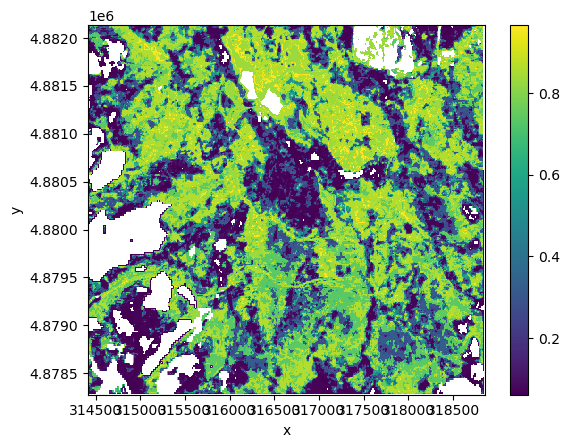

In [ ]:


out_array.plot()  # color ramp = probability that pixel contains beech

In [ ]:
# from Marconi: stacked classifiers


#define models
rf2 = make_pipeline(StandardScaler(),
                    RandomForestClassifier(random_state=0, oob_score = True,
        n_estimators = 300, max_features = 'sqrt', criterion = 'entropy'))


knn2 = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(weights = 'distance', 
                                          p=1, n_neighbors=20))
gb2 = make_pipeline(StandardScaler(),
                    HistGradientBoostingClassifier(random_state=0, 
                    max_iter = 1000, learning_rate = 0.01, 
                max_depth = 25, loss = 'categorical_crossentropy', 
                l2_regularization = 0.5))
mlpc2 = make_pipeline(StandardScaler(), 
                      MLPClassifier(random_state=0, 
                                    beta_2=0.9, max_iter = 1200))

from sklearn.naive_bayes import GaussianNB
bayes2 = make_pipeline(StandardScaler(), GaussianNB())

bsvc2 =make_pipeline(StandardScaler(),
                     BaggingClassifier(
                         base_estimator=SVC(probability = True, C = 1000), 
                        n_jobs = 1, random_state=0))

logc = LogisticRegression(penalty = "elasticnet", solver = "saga", 
                          max_iter = 10000, n_jobs=3, l1_ratio = 0.5)


logc = LogisticRegression(penalty = "elasticnet", solver = "saga", 
                          max_iter = 10000, n_jobs=3, l1_ratio = 0.5)
from mlxtend.classifier import StackingCVClassifier
clf_bl2 = StackingCVClassifier(classifiers = [rf2, gb2, bsvc2, mlpc2, knn2],
            use_probas=True, cv = 3, n_jobs =1,
            meta_classifier= logc)

clf_bl2.fit(X_res, y_res.taxonID.ravel())
print(clf_bl2.score(X_test, y_test['taxonID'].ravel()))

predict_an = clf_bl2.predict_proba(X_test)